In [207]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks

In [208]:
data = yf.download('DNO.OL', start='2003-01-01', end='2023-01-01')['Adj Close']

[*********************100%%**********************]  1 of 1 completed


## Funksjoner

In [209]:
def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

In [210]:
def FFT(x):
    """
    A recursive implementation of 
    the 1D Cooley-Tukey FFT, the 
    input should have a length of 
    power of 2. 
    """
    N = len(x)
    
    if N == 1:
        return x
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        half_N = int(N/2)
        combined = np.concatenate([X_even + factor[:half_N] * X_odd,
                                   X_even + factor[half_N:] * X_odd])
        return combined

In [211]:
def make_sin_data(X):
    num_points = 100  # Du kan justere antallet punkter for å få ønsket glatthet i kurvene
    amplitudes = []
    phases = []
    # Gå gjennom hvert komplekse tall i X for å generere og plotte sinusfunksjonen for hver frekvens
    plt.figure(figsize=(12, 6))
    for x in X[:10]:
        amplitude = np.abs(x)  # Amplituden er størrelsen til det komplekse tallet
        amplitudes.append(amplitude)
        phase = np.angle(x)  # Fasen er vinkelen til det komplekse tallet
        phases += phase

        # Generer x-aksen 
        t = np.linspace(0, 2*np.pi, num_points)  # Her antas det at sinusoiden er én periode

        # Beregn sinusoiden med amplituden og fasen for det gjeldende komplekse tallet
        sin_wave = amplitude * np.sin(t + phase)

        plt.plot(t, sin_wave)

    

    plt.xlabel('Tiden det tar rundt en sirkel')
    plt.ylabel('Amplituden')
    plt.title('Sinus kurver for de 10 første frekvensene')
    plt.grid(True)
    plt.show()

    return amplitudes, phases

In [212]:
def create_sin (peak_freq, complex_func, data, n):
    frekvens = peak_freq
    amplitude = np.abs(complex_func)
    fase = np.angle(complex_func)
    offset = np.mean(x)

    sinwave = amplitude * np.exp(1j * (2 * np.pi * frekvens * n + fase)) + offset

    return sinwave

In [213]:
def fit_sin(n, data, period, complex_func):
    guess_freq = 2 * np.pi / period
    guess_amplitude = np.abs(complex_func)
    guess_phase = np.angle(complex_func)
    guess_offset = np.mean(data)
    
    guess_param = [guess_freq, guess_amplitude, guess_phase, guess_offset]
    
    # Sinus function to be fitted with the parameters
    def sin_func(n, freq, amplitude, phase, offset):
        return np.sin(n * freq + phase) * amplitude + offset

    # scipy.optimize.curve_fit(f, xdata, ydata, p0=None)
    fit = curve_fit(sin_func, n, data, p0=guess_param)

    optimized_params = fit[0]
    
    # Assumes ydata = f(xdata, *params) + eps.
    fitted_sin = sin_func(n, *optimized_params)

    # Finn indeksene til maksimalverdiene (toppene)
    peak_indices = np.where((fitted_sin[:-2] < fitted_sin[1:-1]) & (fitted_sin[1:-1] > fitted_sin[2:]))[0] + 1
    peaks_x = n[peak_indices]
    peaks_y = fitted_sin[peak_indices]

    # Beregn perioden mellom topper (avstanden mellom de to første toppene)
    period = peaks_x[1] - peaks_x[0]

    # Finn indekser for topper i dataene
    # peaks_indices, _ = find_peaks(fitted_sin)

    # # Hent x- og y-verdier for toppene
    # peaks_x = n[peaks_indices]
    # peaks_y = data[peaks_indices]

    # Vis perioden mellom topper
    print(f"Perioden mellom topper: {period}")

    return fitted_sin, fit, peaks_x, peaks_y

### Setting parameters

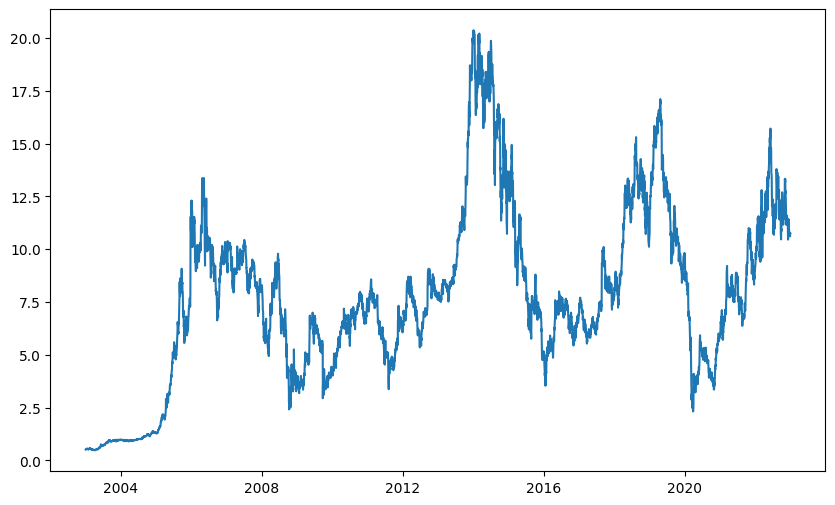

In [214]:
x = np.array(data)
N = len(data)
n = np.arange(N)
lin_trend = len(n)
# Sampling rate
sr = 1

T = N/sr

# freq = n/T

# Sampling interval
ts = 1/sr

# Frequncies
freq = fftfreq(N, ts)

plt.figure (figsize= (10, 6))

plt.plot(data)

## Ulike fourier former

Discrete fourier transform

Fast fourier transform

## Frekvensanalysen

In [215]:
X = fft(data)
# Removing the DC component (index 0) or the average value of the signal
# X = X[1:]

- N//2: It slices the freq array to get the one-sided frequency values, f_oneside, which range from 0 to the Nyquist frequency, which is half of the sampling frequency.

- It slices the X array to get the one-sided DFT coefficients, X_oneside, and normalizes them by dividing by n_oneside. This is to get the correct amplitude values of the signal in the time domain.

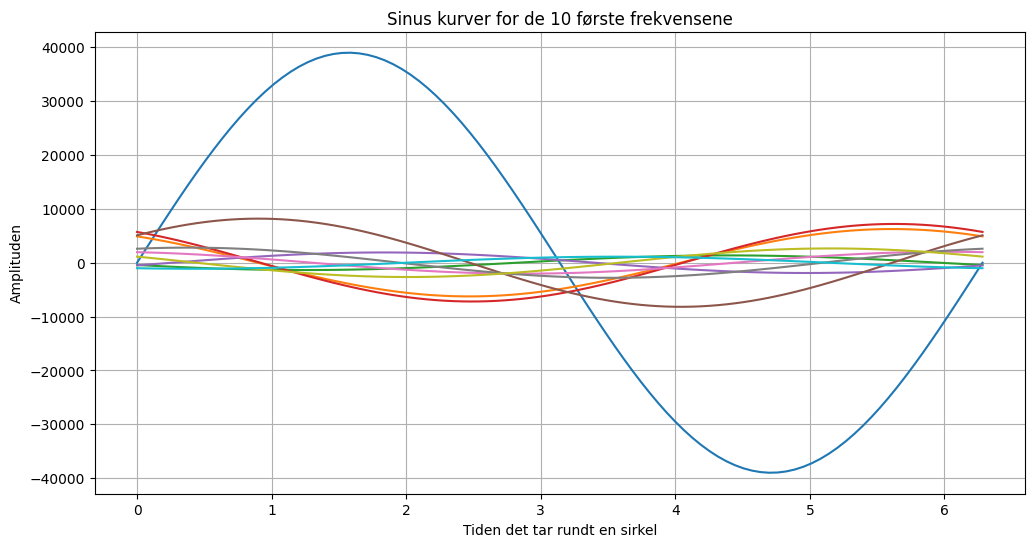

In [216]:
sin_data = make_sin_data(X)

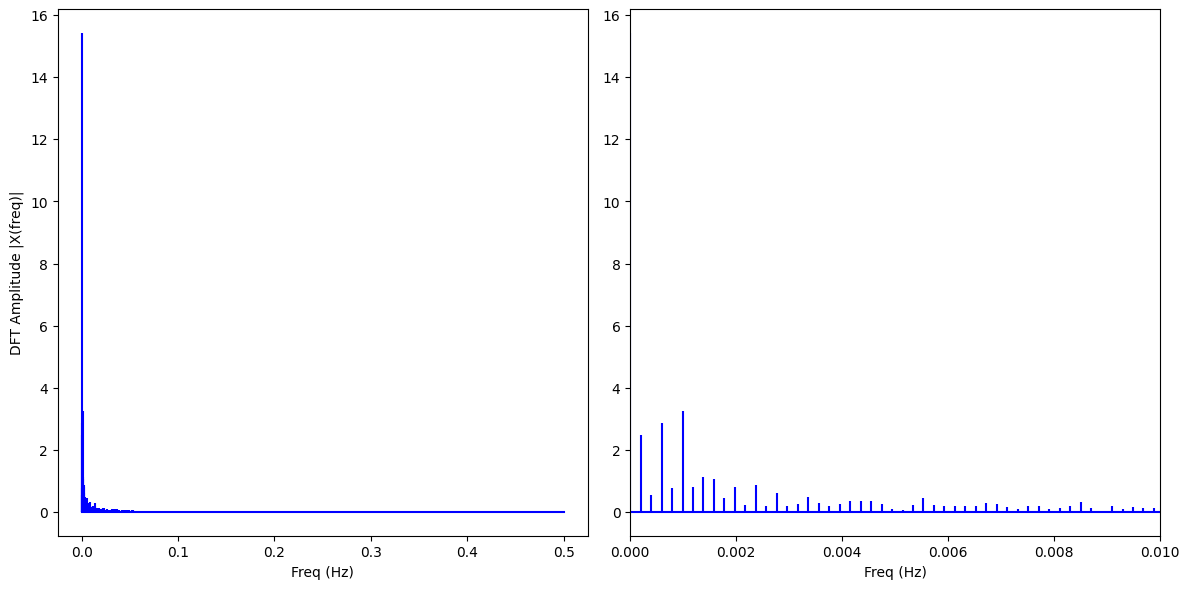

In [217]:
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside = X[:n_oneside]/n_oneside
# X_oneside = X_oneside[1:] + 1

# Finding the amplitudes
amplitudes = np.abs(X_oneside)

# Finding the phases
phases = np.angle(X_oneside)

plt.figure(figsize = (12, 6))

plt.subplot(121)
plt.stem(f_oneside, amplitudes, 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')

plt.subplot(122)
plt.stem(f_oneside, amplitudes, 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.xlim(0, 0.01)
plt.tight_layout()
plt.show()

In [218]:
# convert frequency to days
f_d = 1/f_oneside / (sr)

C:\Users\bugat\AppData\Local\Temp\ipykernel_35324\3807967460.py:2: RuntimeWarning: divide by zero encountered in divide
  f_d = 1/f_oneside / (sr)


In [219]:
# Calculate the absolute values of the DFT coefficients to determine the dominant frequencies within the data
max_amplitude_index = np.argmax(amplitudes[1:])+1

# We find the frequency that matches the maximum amplitude in our time series
peak_freq = f_oneside[max_amplitude_index]

# Finding the max amplitude corresponding to index
max_amplitude = amplitudes[max_amplitude_index]

# Calulating the estimated period of the signal by taking the inverse of the peak frequncy
period = 1 / peak_freq
complex_func = X_oneside[max_amplitude_index]

print('Complex number: ', complex_func)
print('Index of the max ampltiude: ', max_amplitude_index)
print("Corresponding maximum amplitude: ", max_amplitude)
print("Peak frequenzy in Hz:", peak_freq)
print('Period: ', int(period))

Complex number:  (2.536388875326886+2.0099926757175695j)
Index of the max ampltiude:  5
Corresponding maximum amplitude:  3.2362538657095894
Peak frequenzy in Hz: 0.0009881422924901185
Period:  1012


Peak amplitude er lik index 2, som vil si frekvens lik 2

## Sinustilpasning uten minste kvadratsmetode

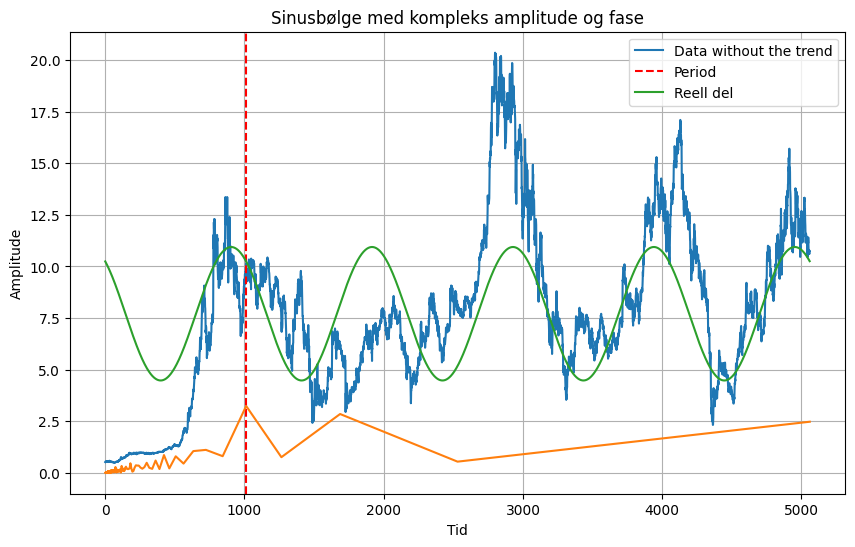

In [220]:
sinwave = create_sin (peak_freq, complex_func, x, n)

# Plott sinusbølgen
plt.figure(figsize=(10, 6))
plt.plot(x, label='Data without the trend')
plt.axvline(x=period, color='red', linestyle='--', label='Period')
plt.plot(f_d, amplitudes)
plt.plot(n, sinwave.real, label='Reell del')
# plt.plot(n, sinwave.imag, label='Imaginær del')

plt.xlabel('Tid')
plt.ylabel('Amplitude')
plt.title('Sinusbølge med kompleks amplitude og fase')
plt.legend()
plt.grid(True)
plt.show()


## Sinustilpasning med minste kvadratsmetode

Perioden mellom topper: 1039


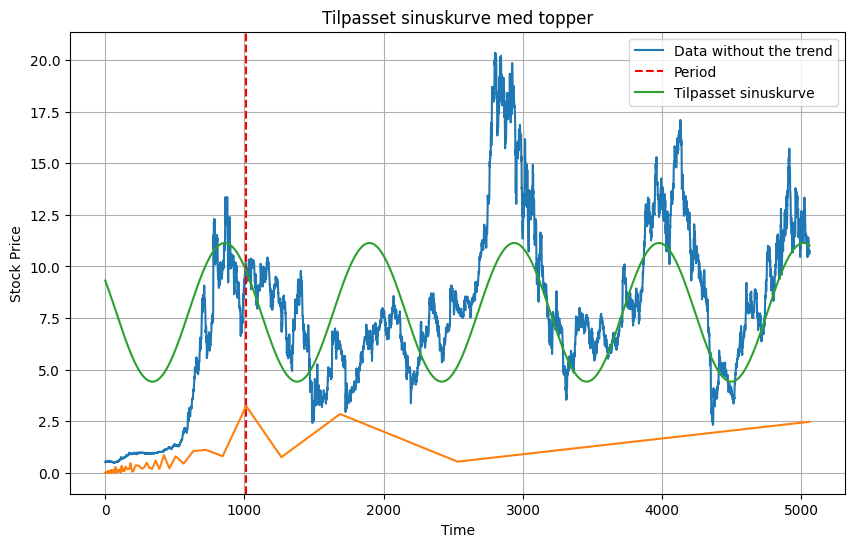

In [221]:
fitted_sin, fit, peaks_x, peaks_y = fit_sin(n, x, period, complex_func)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, label='Data without the trend')
plt.axvline(x=period, color='red', linestyle='--', label='Period')
plt.plot(f_d, amplitudes)

plt.plot(n, fitted_sin, label='Tilpasset sinuskurve')
# plt.scatter(peaks_x, peaks_y, color='red', label='Topper')
# plt.scatter(peaks_x_f, peaks_y_f, color='red', label='Topper')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.title('Tilpasset sinuskurve med topper')
plt.show()

## Prediksjon

In [222]:
def create_fourier_series (f_oneside, X_oneside, data, n, threshold):
    
    fourier_series = np.zeros(len(data), dtype=np.complex128)
    amplitudes = []
    phases = []

    for x in X_oneside:
        amplitude = np.abs(x)  # Amplituden er størrelsen til det komplekse tallet
        amplitudes.append(amplitude)
        phase = np.angle(x)  # Fasen er vinkelen til det komplekse tallet
        phases.append(phase)

    amplitudes = np.array(amplitudes)
    phases = np.array(phases)

    max_amplitude_index = np.argmax(amplitudes[1:])+1
    peak_freq = f_oneside[max_amplitude_index]
    frekvens = peak_freq
    offset = np.mean(data)

    faktor = amplitudes
    significant_freqs = f_oneside[faktor > threshold]
    significant_amps = amplitudes[faktor > threshold]
    significant_phase = phases[faktor > threshold]

    # Legg til de mest signifikante frekvensene i serien
    for i in range(len(significant_freqs)):
        cosine_component = significant_amps[i] * np.cos(2 * np.pi * significant_freqs[i] * np.arange(len(data)) + significant_phase[i])
        sine_component = significant_amps[i] * np.sin(2 * np.pi * significant_freqs[i] * np.arange(len(data)) + significant_phase[i])
        # fourier_series += cosine_component + sine_component

        # Legg til offset som et komplekst tall
        offset_complex = offset + 0j

        # Legg til komplekse sinus- og cosinuskomponenter med offset
        fourier_series += (cosine_component + sine_component) + offset_complex

    return fourier_series

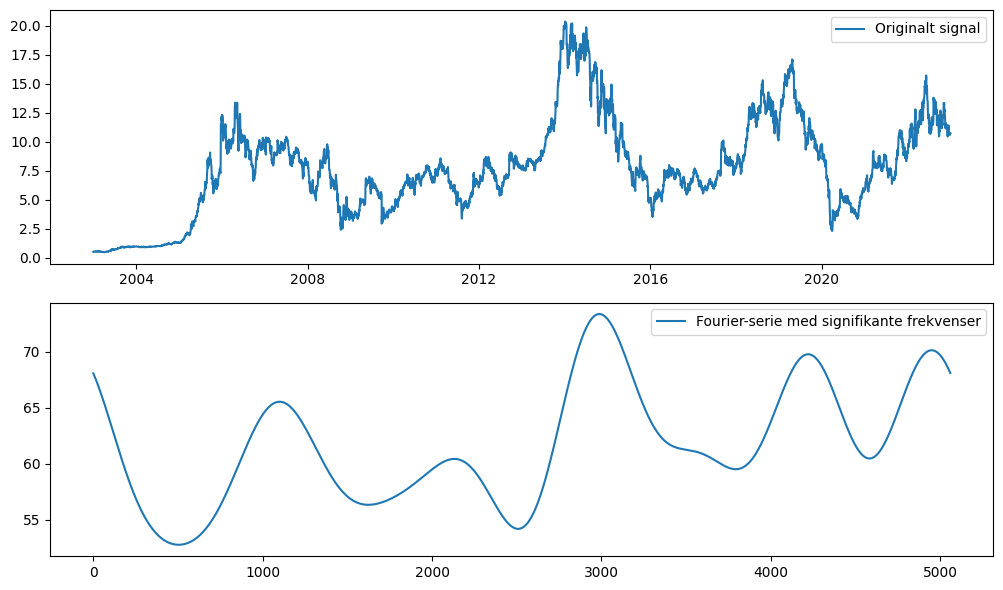

In [232]:
fourier_series = create_fourier_series(f_oneside, X_oneside, data, n, 1)

# Plot det opprinnelige signalet og Fourier-serien
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(data, label='Originalt signal')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(fourier_series, label='Fourier-serie med signifikante frekvenser')
plt.legend()

plt.tight_layout()
plt.show()

In [224]:
# # Lage en fourier-serie som tilnærmer seg prisene
# def fourier_series(n, significant_freqs, significant_amps, significant_phase, x):
#     result = 0
#     offset = np.mean(data)
#     for f, a, p in zip(significant_freqs, significant_amps, significant_phase):
#         term = a * np.cos(2 * np.pi * f * n + p) + offset
#         print(f"Term for n={n}: {term}")
#         result += term
#     return result

# pred_years = 2500

# future_prices = []

# for i in range(N, N + pred_years):
#     future_prices.append(fourier_series(i, significant_freqs, significant_amps, significant_phase, x))

# # Plotte de historiske og fremtidige prisene
# plt.figure(figsize=(12,6))
# plt.plot(range(N), x, label="Historical prices")
# plt.plot(range(N, N + pred_years), future_prices, label="Predicted prices")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

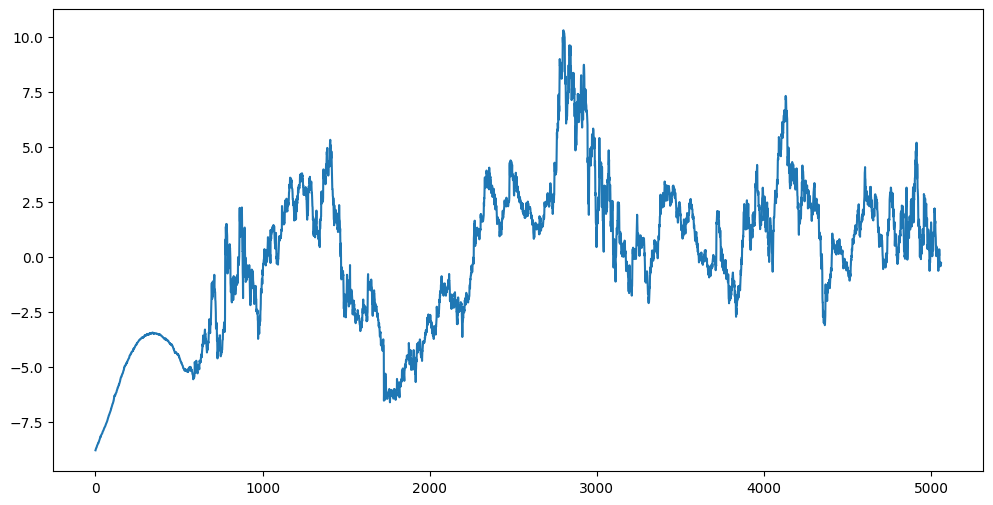

In [225]:
new_x = x - fitted_sin

plt.figure (figsize=(12, 6))
plt.plot(new_x)

In [226]:
new_X = fft(new_x)

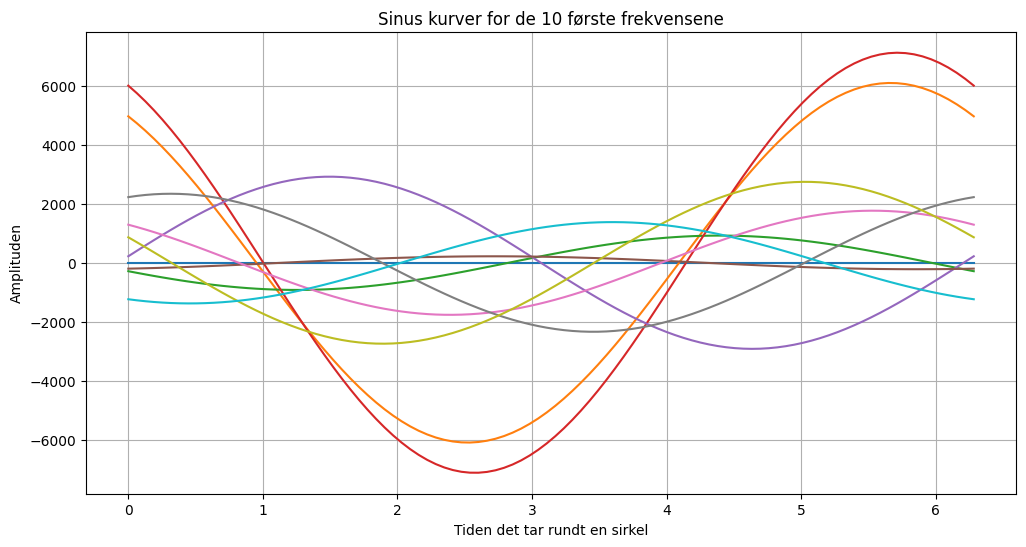

In [227]:
sin_data2 = make_sin_data(new_X)

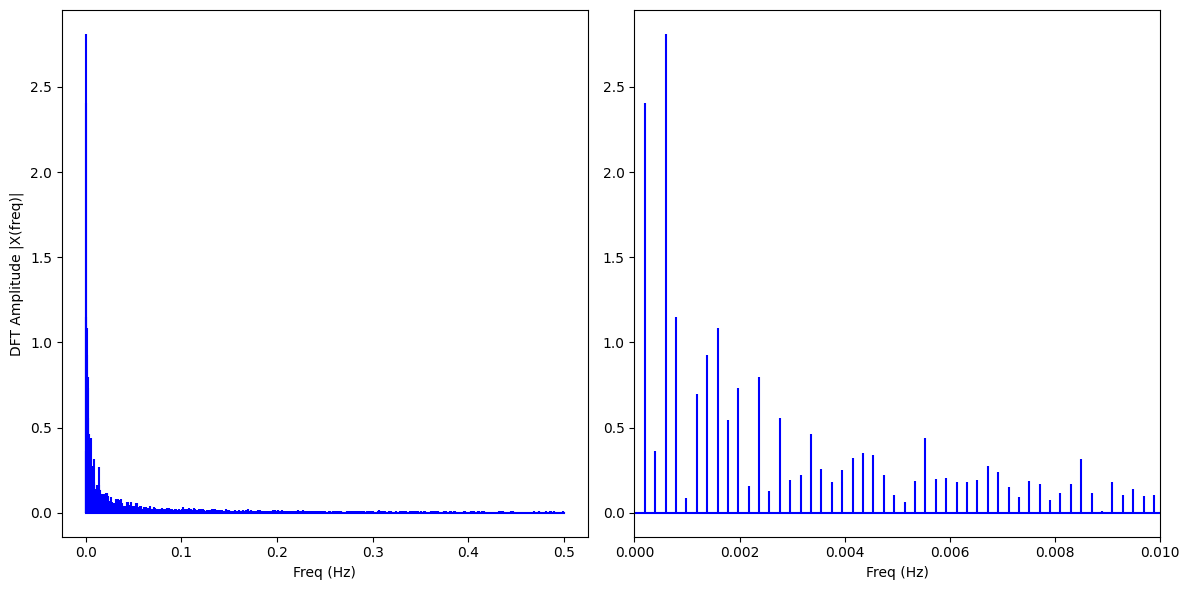

In [228]:
n_oneside = N//2
# get the one side frequency
new_f_oneside = freq[:n_oneside]

# normalize the amplitude
new_X_oneside = new_X[:n_oneside]/n_oneside


plt.figure(figsize = (12, 6))

plt.subplot(121)
plt.stem(f_oneside, abs(new_X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')

plt.subplot(122)
plt.stem(f_oneside, abs(new_X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.xlim(0, 0.01)
plt.tight_layout()
plt.show()

In [229]:
# Calculate the absolute values of the DFT coefficients to determine the dominant frequencies within the data
new_amplitudes = np.abs(new_X_oneside)

# Calculate the absolute values of the DFT coefficients to determine the dominant frequencies within the data
new_max_amplitude_index = np.argmax(amplitudes[1:])+1

# We find the frequency that matches the maximum amplitude in our time series
new_peak_freq = freq[new_max_amplitude_index]

# Finding the max amplitude corresponding to index
new_max_amplitude = new_amplitudes[new_max_amplitude_index]

# Calulating the estimated period of the signal by taking the inverse of the peak frequncy
new_period = 1 / new_peak_freq

print('Complex number:', X_oneside[new_max_amplitude_index])
print("Dominant frequency:", new_peak_freq)
print('Period:', new_period)
print("Corresponding maximum amplitude:", new_max_amplitude)

Complex number: (2.536388875326886+2.0099926757175695j)
Dominant frequency: 0.0009881422924901185
Period: 1012.0000000000001
Corresponding maximum amplitude: 0.08646735720891459


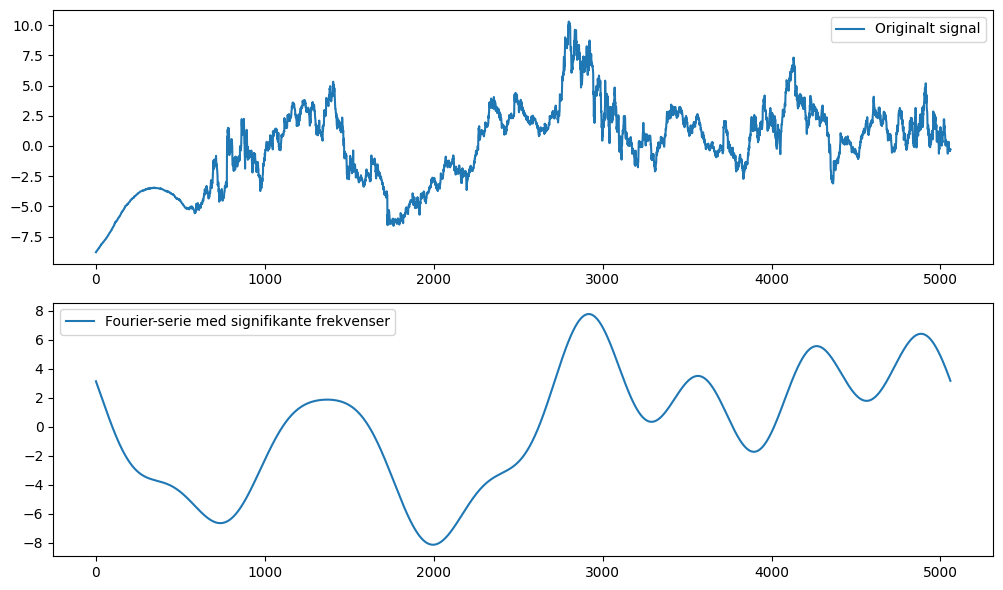

In [230]:
fourier_series = create_fourier_series(new_f_oneside, new_X_oneside, new_x, n, 0.80)

# Plot det opprinnelige signalet og Fourier-serien
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(new_x, label='Originalt signal')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(fourier_series, label='Fourier-serie med signifikante frekvenser')
plt.legend()

plt.tight_layout()
plt.show()

Perioden mellom topper: 875


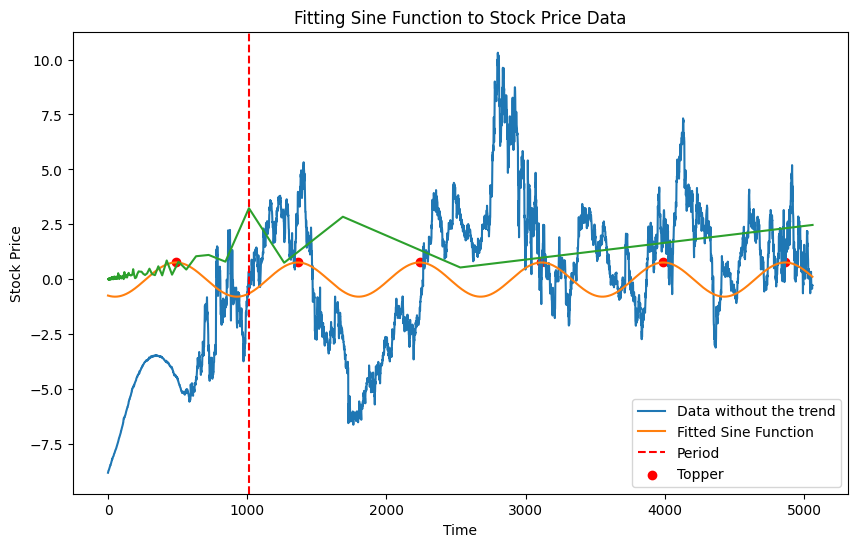

In [231]:
    fitted_sin_2, fit_2, peaks_x2, peaks_y2 = fit_sin(n, new_x, new_period, complex_func)
    
    plt.figure(figsize=(10, 6))
    plt.plot(new_x, label='Data without the trend')
    plt.plot(fitted_sin_2, label='Fitted Sine Function')
    plt.axvline(x=new_period, color='red', linestyle='--', label='Period')
    plt.plot(f_d, amplitudes)
    plt.scatter(peaks_x2, peaks_y2, color='red', label='Topper')

    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.title('Fitting Sine Function to Stock Price Data')
    plt.show()